# Double-diSPIM Deskewing Pipeline

This notebook processes raw double-diSPIM data by deskewing the 45° sheared slices from each camera into rectilinear volumes.

## Pipeline Overview

1. **Deskewing**: Remove 45° shear from light sheet imaging for all 4 cameras
2. **Save Deskewed Volumes**: Save all 4 deskewed volumes for interactive 3D alignment
3. **Visualization**: Display various camera combinations to help understand the data

## System Geometry

- **Alpha Arm (Top)**: Two cameras (A, B) viewing from above
- **Beta Arm (Bottom)**: Two cameras (C, D) viewing from below
- Each camera captures 45° sheared slices that need deskewing
- After deskewing, volumes will be aligned interactively using a 3D visualization tool


## Section 1: Setup and Imports


In [1]:
# NumPy 2.0 compatibility: Some libraries (xarray, dask) may use deprecated np.unicode_
# Add compatibility shim immediately after importing numpy, before other imports
import numpy as np
if not hasattr(np, 'unicode_'):
    np.unicode_ = np.str_

import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import data loading functions
from utils import (
    parse_metadata,
    load_ome_tiff,
    discover_acquisitions,
    extract_spatial_info,
    scale_image_for_display,
    create_camera_overlay,
    create_side_by_side_frame
)

# Import processing functions
from processing import (
    deskew_stack,
    compute_mip,
    # Save/load functions
    save_deskewed_stack,
    load_deskewed_stack,
    check_deskewed_exists,
    get_deskewed_paths
)

# Set up matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100

print("Libraries imported successfully!")


Libraries imported successfully!


## Section 2: Load Data and Define Parameters


In [2]:
# Discover acquisitions
acquisitions = discover_acquisitions('./datasets')
print(f"Found {len(acquisitions)} acquisition pairs")

# Select acquisition to process
ACQUISITION_INDEX = 0

if len(acquisitions) > ACQUISITION_INDEX:
    selected_acq = acquisitions[ACQUISITION_INDEX]
    print(f"\nSelected: {selected_acq['condition']}/{selected_acq['run']}")
else:
    print(f"Error: Acquisition index {ACQUISITION_INDEX} not available")
    selected_acq = None


Found 9 acquisition pairs

Selected: 10msec_worm/I


In [3]:
# Load metadata
if selected_acq:
    alpha_meta = parse_metadata(selected_acq['alpha_metadata'])
    beta_meta = parse_metadata(selected_acq['beta_metadata'])
    
    # Extract key parameters for processing
    pixel_size_um = extract_spatial_info(alpha_meta, beta_meta)['pixel_size_um']['average']
    z_step_um = extract_spatial_info(alpha_meta, beta_meta)['z_step_um']['average']
    
    print(f"Processing parameters:")
    print(f"  Pixel size: {pixel_size_um:.4f} μm")
    print(f"  Z-step: {z_step_um:.4f} μm")
    print(f"  Light sheet angle: 45° (standard for diSPIM)")
    
    # Configuration for saving deskewed volumes
    OUTPUT_DIR = Path('./processed_output')  # Base directory for saved results
    
    # Force flag: Set to True to force re-deskewing even if files exist
    FORCE_REDESKEW = False  # Force re-deskewing
    
    # For testing, you may want to load a subset of slices
    # Set to None to load full stack
    MAX_SLICES_FOR_PROCESSING = None  # Change to smaller number (e.g., 50) for faster testing
    
    print(f"\nLoading image data...")
    print(f"  Max slices: {MAX_SLICES_FOR_PROCESSING if MAX_SLICES_FOR_PROCESSING else 'All'}")
    
    # Load all cameras from both arms
    alpha_data = load_ome_tiff(
        selected_acq['alpha_tiff'],
        metadata=alpha_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_PROCESSING
    )
    
    beta_data = load_ome_tiff(
        selected_acq['beta_tiff'],
        metadata=beta_meta,
        channel_idx=None,  # Load all cameras
        max_slices=MAX_SLICES_FOR_PROCESSING
    )
    
    print(f"\nData loaded:")
    print(f"  Alpha shape: {alpha_data.shape}")
    print(f"  Beta shape: {beta_data.shape}")
    print(f"  Alpha cameras: {alpha_meta['channel_names']}")
    print(f"  Beta cameras: {beta_meta['channel_names']}")
    
    # Create acquisition name for file paths
    acquisition_name = f"{selected_acq['condition']}_{selected_acq['run']}"
else:
    print("No acquisition selected")
    alpha_data = None
    beta_data = None
    OUTPUT_DIR = None
    SAVE_INTERMEDIATES = True
    FORCE_REDESKEW = False
    FORCE_ALIGNMENT = False
    FORCE_ROUGH_ALIGN = False
    FORCE_REGISTRATION = False
    FORCE_FUSION = False
    acquisition_name = None


Processing parameters:
  Pixel size: 0.1220 μm
  Z-step: 0.7000 μm
  Light sheet angle: 45° (standard for diSPIM)

Loading image data...
  Max slices: All
Loading OME-TIFF: datasets/10msec_worm/I/beads_alpha_worm2_4/beads_alpha_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)
Loading OME-TIFF: datasets/10msec_worm/I/beads_beta_worm2_4/beads_beta_worm2_MMStack_Pos0.ome.tif
Raw data shape: (200, 2, 2304, 2304)
Data dtype: uint16
Final data shape: (200, 2, 2304, 2304)

Data loaded:
  Alpha shape: (200, 2, 2304, 2304)
  Beta shape: (200, 2, 2304, 2304)
  Alpha cameras: ['HamCam2', 'HamCam1']
  Beta cameras: ['HamuHam4', 'HamuHam3']


## Phase 1: Deskewing

Remove the 45° shear from the raw light sheet data. Each camera stack is deskewed independently.

**Note on Save/Load**: Deskewed results are automatically saved to `processed_output/` and will be loaded on subsequent runs to avoid re-running this time-intensive step. To force re-deskewing, set `FORCE_REDESKEW = True` in the configuration cell above.


In [4]:
if alpha_data is not None and beta_data is not None:
    print("=" * 70)
    print("PHASE 1: DESKEWING")
    print("=" * 70)
    
    # Extract individual camera stacks
    # Alpha arm: cameras 0 and 1
    alpha_cam0_raw = alpha_data[:, 0, :, :]  # Shape: (Z, Y, X)
    alpha_cam1_raw = alpha_data[:, 1, :, :]
    
    # Beta arm: cameras 0 and 1
    beta_cam0_raw = beta_data[:, 0, :, :]
    beta_cam1_raw = beta_data[:, 1, :, :]
    
    # Dictionary to store transform info for all cameras
    deskew_info = {}
    
    # Process Alpha Camera 0
    cam0_name = alpha_meta['channel_names'][0]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam0_name, 'alpha'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Alpha Camera 0 ({cam0_name})...")
        alpha_cam0_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['alpha_cam0'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {alpha_cam0_deskewed.shape}")
    else:
        print(f"\nDeskewing Alpha Camera 0 ({cam0_name})...")
        alpha_cam0_deskewed, info0 = deskew_stack(
            alpha_cam0_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['alpha_cam0'] = info0
        print(f"  Input shape: {info0['input_shape']}")
        print(f"  Output shape: {info0['output_shape']}")
        
        # Always save deskewed volumes
        stack_path, meta_path = get_deskewed_paths(
            OUTPUT_DIR, acquisition_name, cam0_name, 'alpha'
        )
        save_deskewed_stack(
            alpha_cam0_deskewed, stack_path, 
            transform_info=info0,
            metadata={'camera': cam0_name, 'arm': 'alpha', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
        )
        print(f"  Saved to: {stack_path}")
    
    # Process Alpha Camera 1
    cam1_name = alpha_meta['channel_names'][1]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam1_name, 'alpha'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Alpha Camera 1 ({cam1_name})...")
        alpha_cam1_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['alpha_cam1'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {alpha_cam1_deskewed.shape}")
    else:
        print(f"\nDeskewing Alpha Camera 1 ({cam1_name})...")
        alpha_cam1_deskewed, info1 = deskew_stack(
            alpha_cam1_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['alpha_cam1'] = info1
        
        # Always save deskewed volumes
        stack_path, meta_path = get_deskewed_paths(
            OUTPUT_DIR, acquisition_name, cam1_name, 'alpha'
        )
        save_deskewed_stack(
            alpha_cam1_deskewed, stack_path,
            transform_info=info1,
            metadata={'camera': cam1_name, 'arm': 'alpha', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
        )
        print(f"  Saved to: {stack_path}")
    
    # Process Beta Camera 0
    cam0_name = beta_meta['channel_names'][0]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam0_name, 'beta'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Beta Camera 0 ({cam0_name})...")
        beta_cam0_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['beta_cam0'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {beta_cam0_deskewed.shape}")
    else:
        print(f"\nDeskewing Beta Camera 0 ({cam0_name})...")
        beta_cam0_deskewed, info2 = deskew_stack(
            beta_cam0_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['beta_cam0'] = info2
        print(f"  Input shape: {info2['input_shape']}")
        print(f"  Output shape: {info2['output_shape']}")
        
        # Always save deskewed volumes
        stack_path, meta_path = get_deskewed_paths(
            OUTPUT_DIR, acquisition_name, cam0_name, 'beta'
        )
        save_deskewed_stack(
            beta_cam0_deskewed, stack_path,
            transform_info=info2,
            metadata={'camera': cam0_name, 'arm': 'beta', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
        )
        print(f"  Saved to: {stack_path}")
    
    # Process Beta Camera 1
    cam1_name = beta_meta['channel_names'][1]
    exists, stack_path, meta_path = check_deskewed_exists(
        OUTPUT_DIR, acquisition_name, cam1_name, 'beta'
    )
    
    if exists and not FORCE_REDESKEW:
        print(f"\nLoading existing deskewed Beta Camera 1 ({cam1_name})...")
        beta_cam1_deskewed, loaded_meta = load_deskewed_stack(stack_path)
        if loaded_meta and 'transform_info' in loaded_meta:
            deskew_info['beta_cam1'] = loaded_meta['transform_info']
        print(f"  Loaded shape: {beta_cam1_deskewed.shape}")
    else:
        print(f"\nDeskewing Beta Camera 1 ({cam1_name})...")
        beta_cam1_deskewed, info3 = deskew_stack(
            beta_cam1_raw, pixel_size_um, z_step_um, angle_deg=45.0
        )
        deskew_info['beta_cam1'] = info3
        
        # Always save deskewed volumes
        stack_path, meta_path = get_deskewed_paths(
            OUTPUT_DIR, acquisition_name, cam1_name, 'beta'
        )
        save_deskewed_stack(
            beta_cam1_deskewed, stack_path,
            transform_info=info3,
            metadata={'camera': cam1_name, 'arm': 'beta', 'pixel_size_um': pixel_size_um, 'z_step_um': z_step_um}
        )
        print(f"  Saved to: {stack_path}")
    
    print("\n" + "=" * 70)
    print("DESKEWING COMPLETE - All volumes saved!")
    print("=" * 70)
    print(f"\nSaved deskewed volumes to: {OUTPUT_DIR / acquisition_name / 'deskewed'}")
    print(f"\nVolumes saved:")
    print(f"  - Alpha Camera 0 ({alpha_meta['channel_names'][0]})")
    print(f"  - Alpha Camera 1 ({alpha_meta['channel_names'][1]})")
    print(f"  - Beta Camera 0 ({beta_meta['channel_names'][0]})")
    print(f"  - Beta Camera 1 ({beta_meta['channel_names'][1]})")
    print(f"\nNote: Set FORCE_REDESKEW=True to force re-deskewing even if files exist")
else:
    print("No data loaded")


PHASE 1: DESKEWING

Loading existing deskewed Alpha Camera 0 (HamCam2)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Alpha Camera 1 (HamCam1)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Beta Camera 0 (HamuHam4)...
  Loaded shape: (200, 2304, 3452)

Loading existing deskewed Beta Camera 1 (HamuHam3)...
  Loaded shape: (200, 2304, 3452)

DESKEWING COMPLETE - All volumes saved!

Saved deskewed volumes to: processed_output/10msec_worm_I/deskewed

Volumes saved:
  - Alpha Camera 0 (HamCam2)
  - Alpha Camera 1 (HamCam1)
  - Beta Camera 0 (HamuHam4)
  - Beta Camera 1 (HamuHam3)

Note: Set FORCE_REDESKEW=True to force re-deskewing even if files exist


### Visualize Deskewing Results

Compare raw vs deskewed Maximum Intensity Projections (MIPs) to verify the transformation.


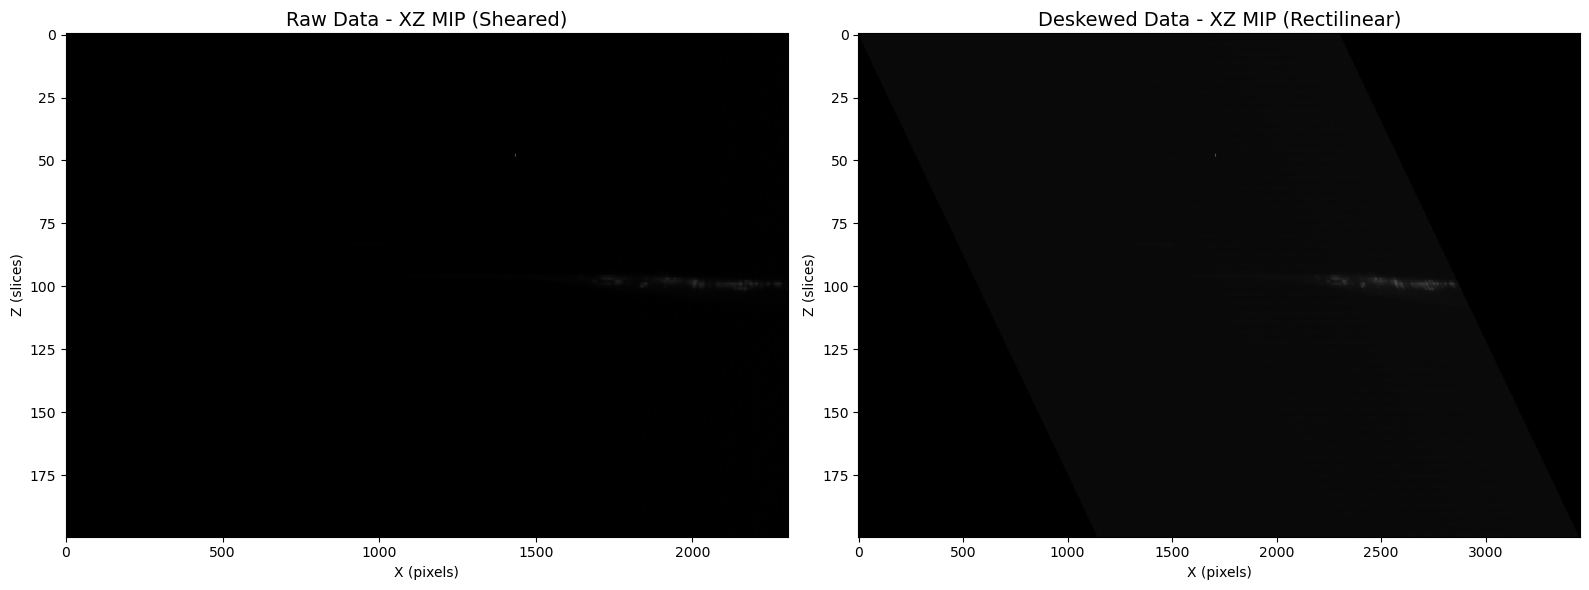


Note: In the deskewed version, spherical objects should appear circular,
not elongated/oval as in the raw sheared data.


In [5]:
if alpha_data is not None:
    # Compute MIPs for visualization
    # XZ view: project along Y axis
    alpha_cam0_raw_xz = compute_mip(alpha_cam0_raw, axis=1)
    alpha_cam0_deskewed_xz = compute_mip(alpha_cam0_deskewed, axis=1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Raw XZ MIP
    raw_scaled, _, _ = scale_image_for_display(alpha_cam0_raw_xz)
    axes[0].imshow(raw_scaled, cmap='gray', aspect='auto')
    axes[0].set_title('Raw Data - XZ MIP (Sheared)', fontsize=14)
    axes[0].set_xlabel('X (pixels)')
    axes[0].set_ylabel('Z (slices)')
    
    # Deskewed XZ MIP
    deskewed_scaled, _, _ = scale_image_for_display(alpha_cam0_deskewed_xz)
    axes[1].imshow(deskewed_scaled, cmap='gray', aspect='auto')
    axes[1].set_title('Deskewed Data - XZ MIP (Rectilinear)', fontsize=14)
    axes[1].set_xlabel('X (pixels)')
    axes[1].set_ylabel('Z (slices)')
    
    plt.tight_layout()
    plt.show()
    
    print("\nNote: In the deskewed version, spherical objects should appear circular,")
    print("not elongated/oval as in the raw sheared data.")


## Visualization: Camera Combinations

Visualize different combinations of cameras to understand spatial relationships:
1. **Same-arm camera overlays**: Show how cameras within each arm relate
2. **Cross-arm comparisons**: Compare cameras from different arms side-by-side
3. **Same camera index**: Compare Camera 0 from Alpha vs Beta, Camera 1 from Alpha vs Beta


### 1. Same-Arm Camera Overlays

Show red/green overlays of the two cameras within each arm (accounting for mirror image relationship).


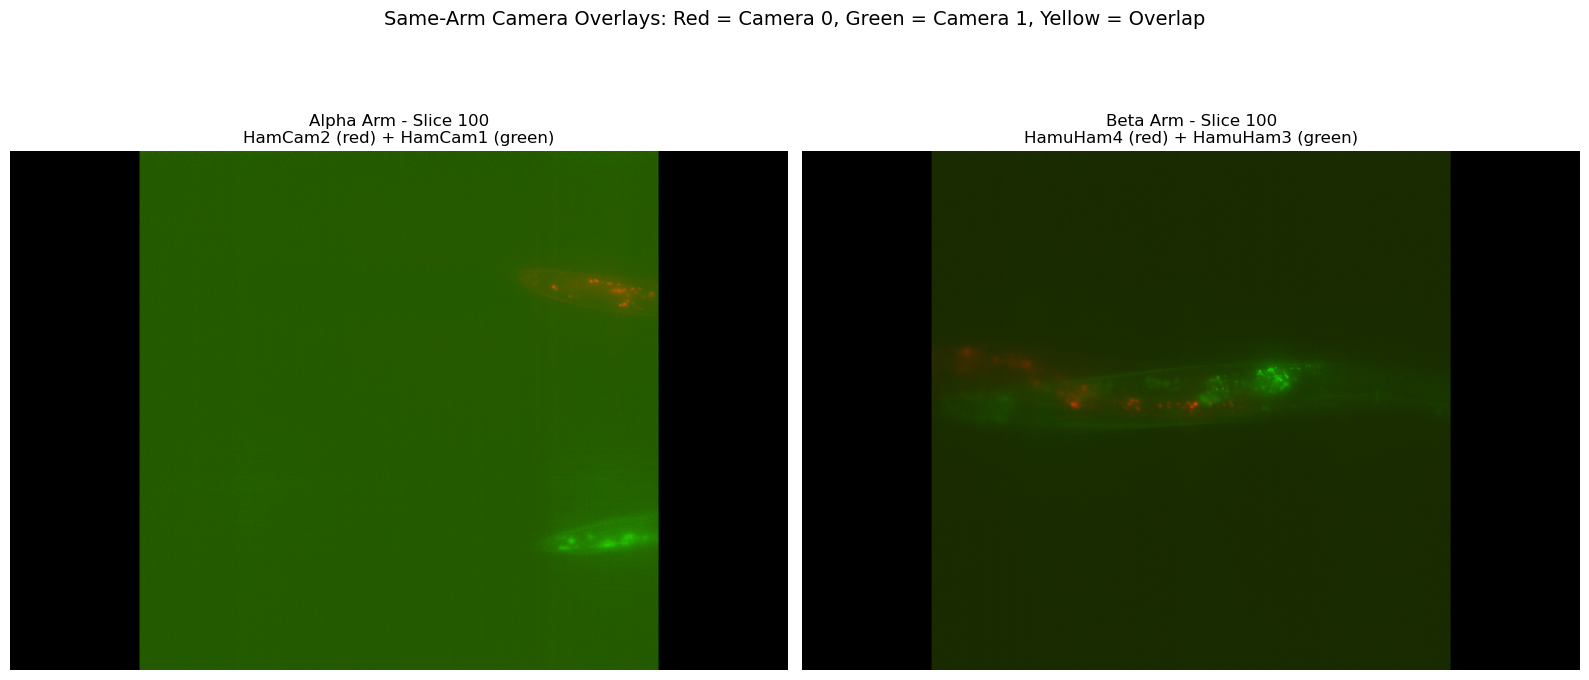

In [6]:
if alpha_data is not None:
    # Select a slice in the middle of the volume
    slice_idx = alpha_cam0_deskewed.shape[0] // 2
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Alpha arm overlay (with horizontal flip to account for mirror images)
    alpha_overlay = create_camera_overlay(
        alpha_cam0_deskewed[slice_idx, :, :],
        alpha_cam1_deskewed[slice_idx, :, :],
        alpha_meta['channel_names'][0],
        alpha_meta['channel_names'][1],
        flip_cam2_horizontal=True  # Account for mirror image relationship
    )
    axes[0].imshow(alpha_overlay, aspect='equal')
    axes[0].set_title(f'Alpha Arm - Slice {slice_idx}\n{alpha_meta["channel_names"][0]} (red) + {alpha_meta["channel_names"][1]} (green)', fontsize=12)
    axes[0].axis('off')
    
    # Beta arm overlay (with horizontal flip to account for mirror images)
    beta_overlay = create_camera_overlay(
        beta_cam0_deskewed[slice_idx, :, :],
        beta_cam1_deskewed[slice_idx, :, :],
        beta_meta['channel_names'][0],
        beta_meta['channel_names'][1],
        flip_cam2_horizontal=True  # Account for mirror image relationship
    )
    axes[1].imshow(beta_overlay, aspect='equal')
    axes[1].set_title(f'Beta Arm - Slice {slice_idx}\n{beta_meta["channel_names"][0]} (red) + {beta_meta["channel_names"][1]} (green)', fontsize=12)
    axes[1].axis('off')
    
    plt.suptitle('Same-Arm Camera Overlays: Red = Camera 0, Green = Camera 1, Yellow = Overlap', fontsize=14)
    plt.tight_layout()
    plt.show()


### 2. Cross-Arm Comparisons: Same Camera Index

Compare Camera 0 from Alpha vs Beta, and Camera 1 from Alpha vs Beta.


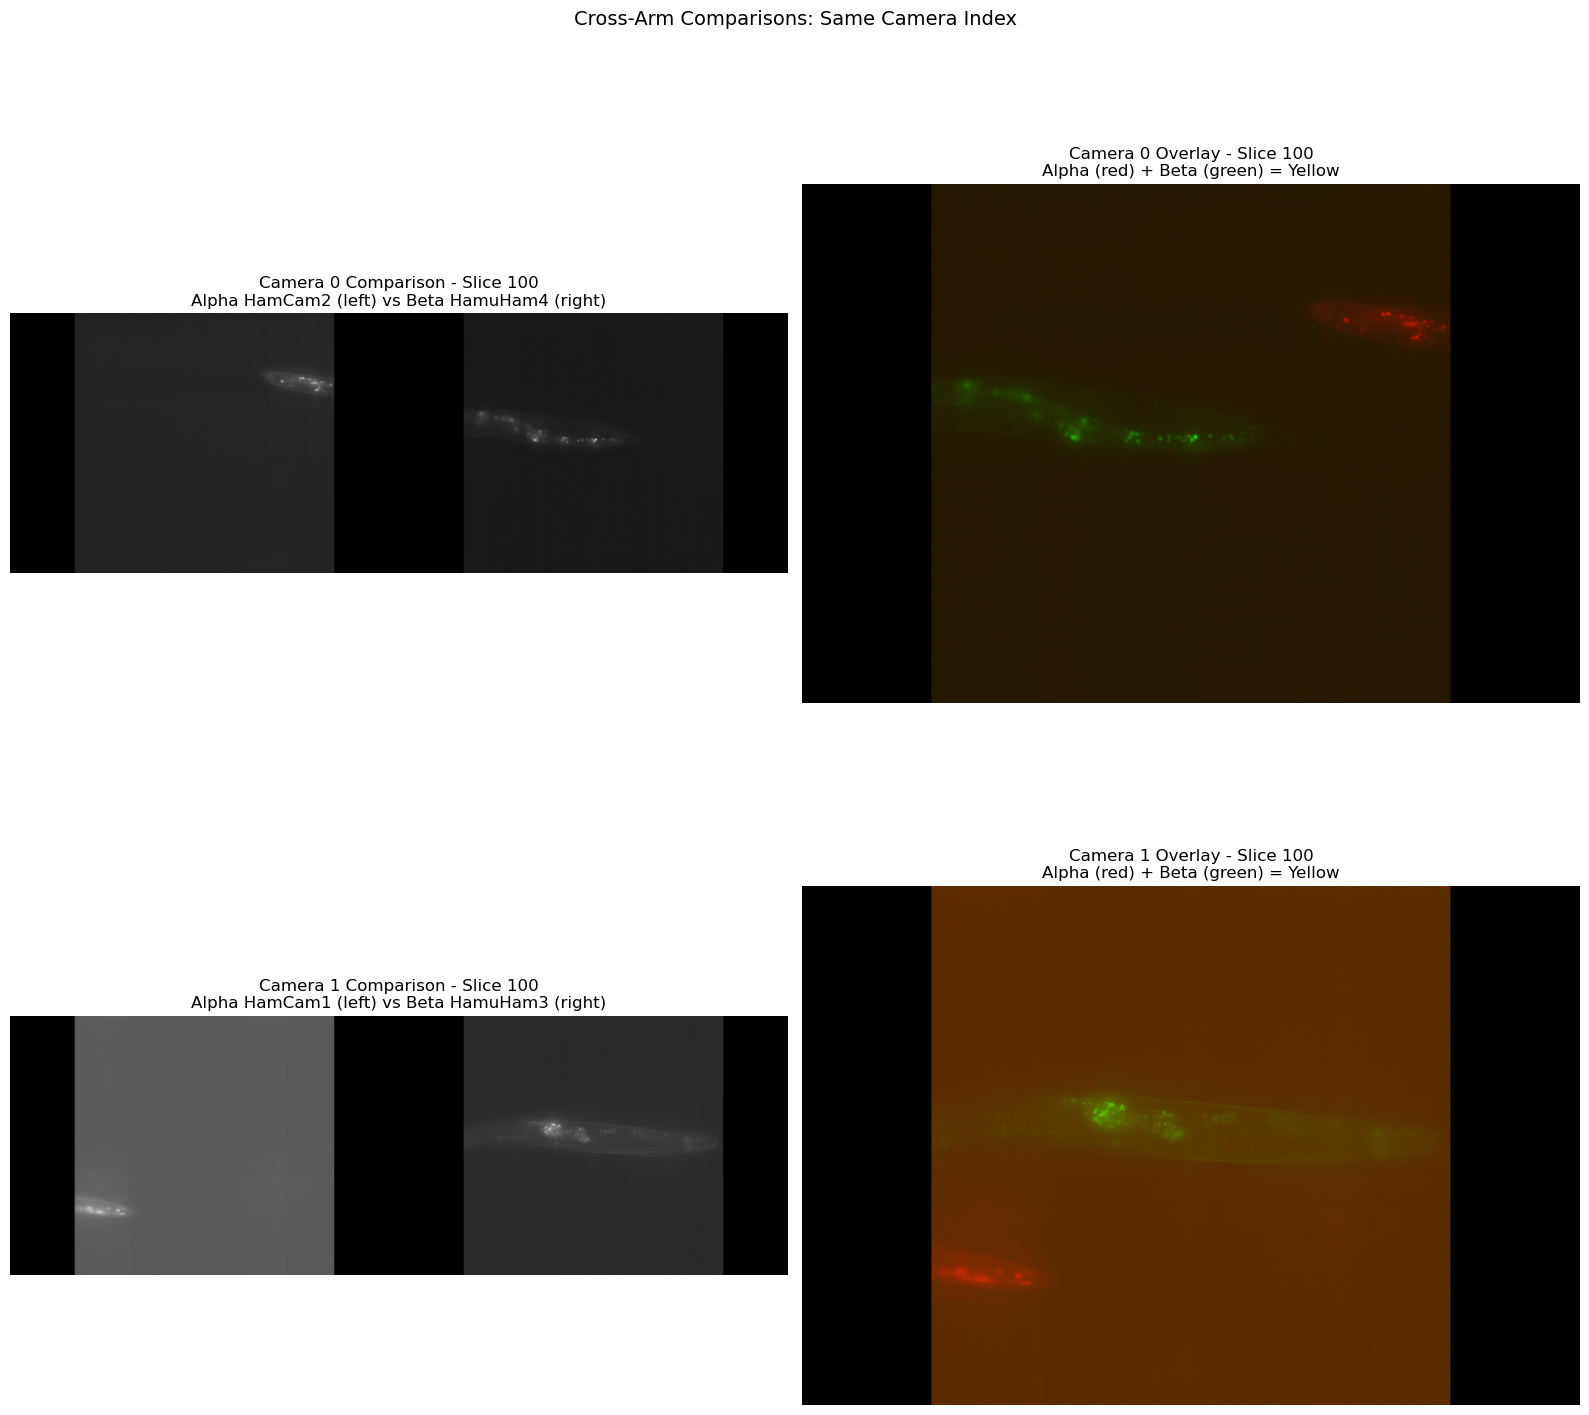

In [7]:
if alpha_data is not None:
    slice_idx = alpha_cam0_deskewed.shape[0] // 2
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Camera 0: Alpha vs Beta side-by-side
    frame_cam0, _, _, _, _ = create_side_by_side_frame(
        alpha_cam0_deskewed[slice_idx, :, :],
        beta_cam0_deskewed[slice_idx, :, :],
        normalize=False
    )
    axes[0, 0].imshow(frame_cam0, cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title(f'Camera 0 Comparison - Slice {slice_idx}\nAlpha {alpha_meta["channel_names"][0]} (left) vs Beta {beta_meta["channel_names"][0]} (right)', fontsize=12)
    axes[0, 0].axis('off')
    
    # Camera 0: Alpha vs Beta overlay
    overlay_cam0 = np.zeros((alpha_cam0_deskewed.shape[1], alpha_cam0_deskewed.shape[2], 3))
    alpha_cam0_scaled, _, _ = scale_image_for_display(alpha_cam0_deskewed[slice_idx, :, :])
    beta_cam0_scaled, _, _ = scale_image_for_display(beta_cam0_deskewed[slice_idx, :, :])
    overlay_cam0[:, :, 0] = alpha_cam0_scaled  # Red = Alpha
    overlay_cam0[:, :, 1] = beta_cam0_scaled   # Green = Beta
    axes[0, 1].imshow(overlay_cam0, aspect='equal')
    axes[0, 1].set_title(f'Camera 0 Overlay - Slice {slice_idx}\nAlpha (red) + Beta (green) = Yellow', fontsize=12)
    axes[0, 1].axis('off')
    
    # Camera 1: Alpha vs Beta side-by-side
    frame_cam1, _, _, _, _ = create_side_by_side_frame(
        alpha_cam1_deskewed[slice_idx, :, :],
        beta_cam1_deskewed[slice_idx, :, :],
        normalize=False
    )
    axes[1, 0].imshow(frame_cam1, cmap='gray', vmin=0, vmax=1)
    axes[1, 0].set_title(f'Camera 1 Comparison - Slice {slice_idx}\nAlpha {alpha_meta["channel_names"][1]} (left) vs Beta {beta_meta["channel_names"][1]} (right)', fontsize=12)
    axes[1, 0].axis('off')
    
    # Camera 1: Alpha vs Beta overlay
    overlay_cam1 = np.zeros((alpha_cam1_deskewed.shape[1], alpha_cam1_deskewed.shape[2], 3))
    alpha_cam1_scaled, _, _ = scale_image_for_display(alpha_cam1_deskewed[slice_idx, :, :])
    beta_cam1_scaled, _, _ = scale_image_for_display(beta_cam1_deskewed[slice_idx, :, :])
    overlay_cam1[:, :, 0] = alpha_cam1_scaled  # Red = Alpha
    overlay_cam1[:, :, 1] = beta_cam1_scaled   # Green = Beta
    axes[1, 1].imshow(overlay_cam1, aspect='equal')
    axes[1, 1].set_title(f'Camera 1 Overlay - Slice {slice_idx}\nAlpha (red) + Beta (green) = Yellow', fontsize=12)
    axes[1, 1].axis('off')
    
    plt.suptitle('Cross-Arm Comparisons: Same Camera Index', fontsize=14)
    plt.tight_layout()
    plt.show()


### 3. Cross-Arm Comparisons: Different Camera Indices

Compare different camera combinations across arms.


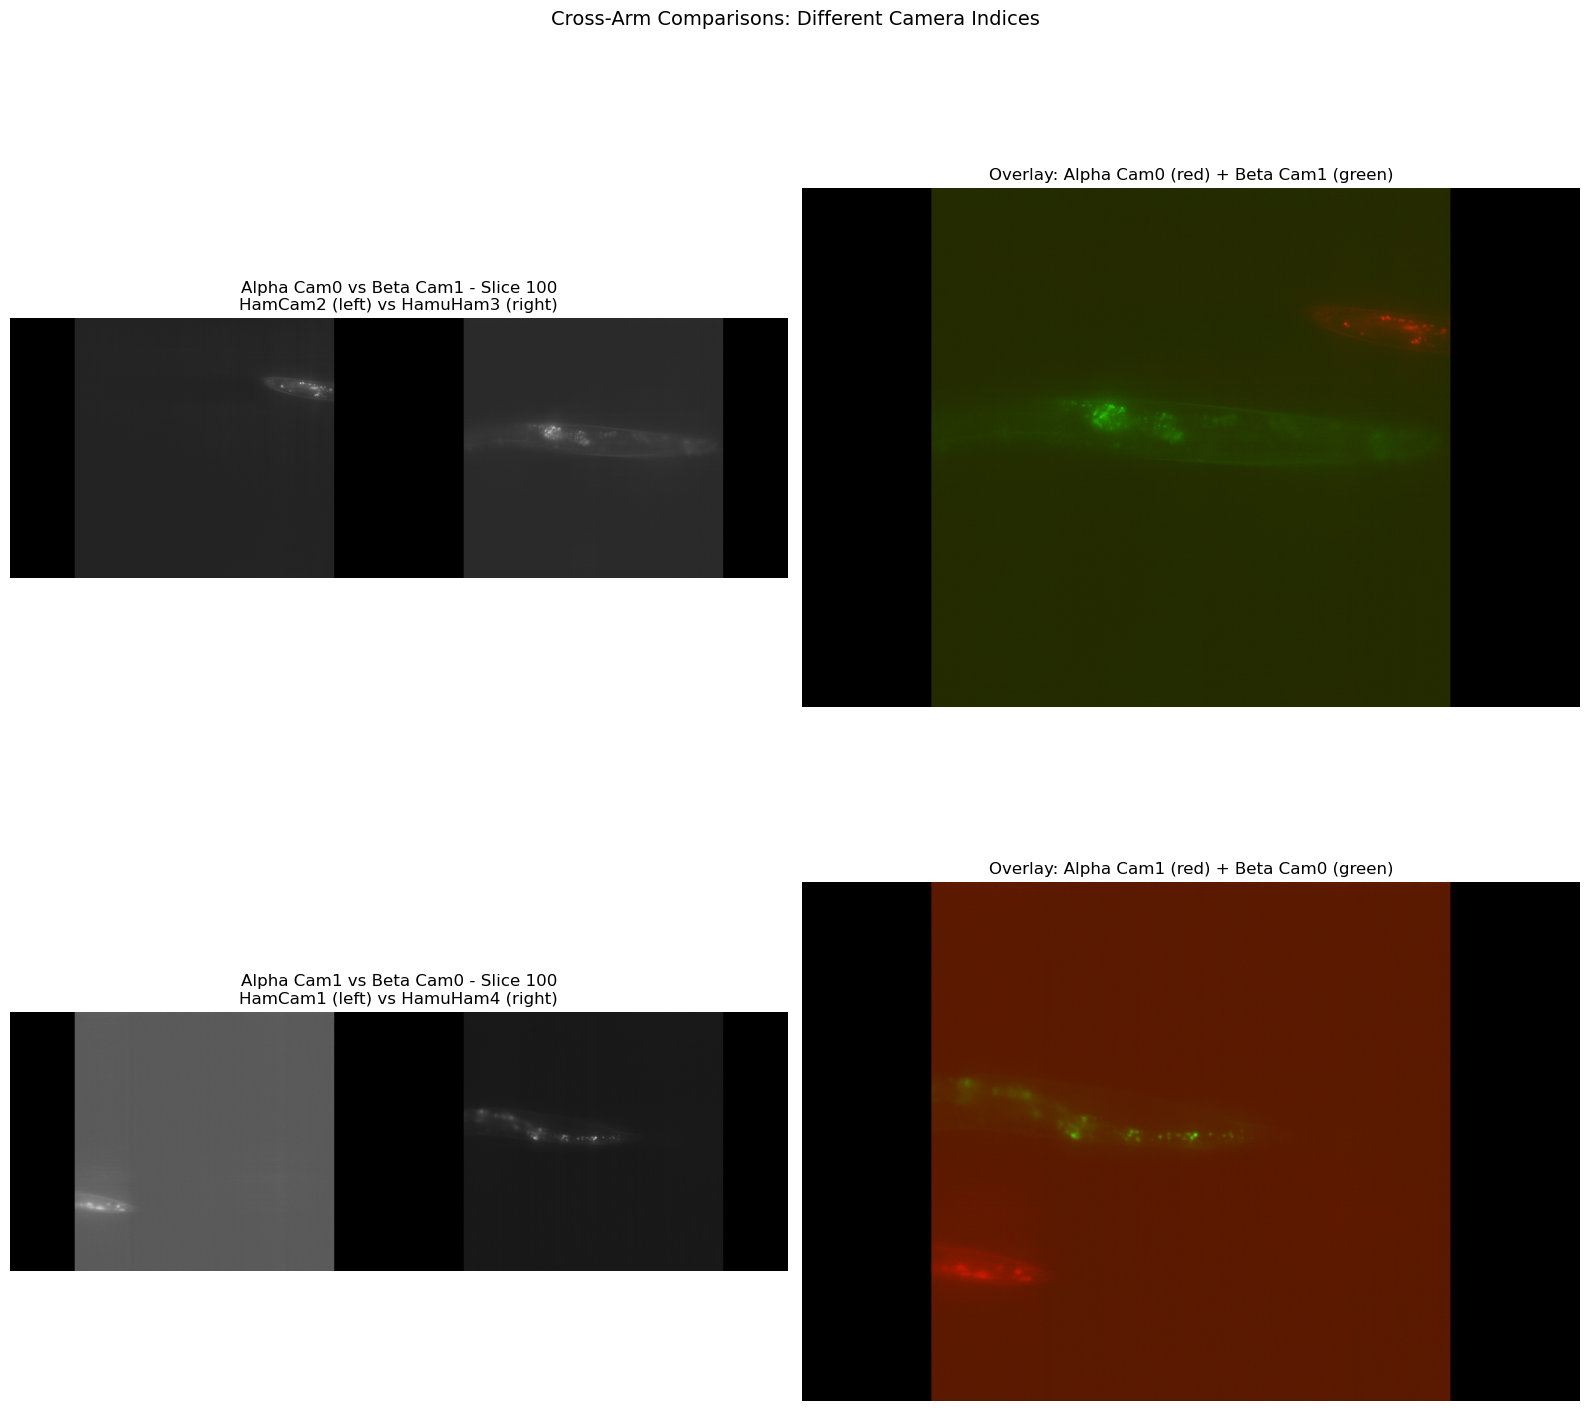

In [8]:
if alpha_data is not None:
    slice_idx = alpha_cam0_deskewed.shape[0] // 2
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    # Alpha Camera 0 vs Beta Camera 1
    frame_01, _, _, _, _ = create_side_by_side_frame(
        alpha_cam0_deskewed[slice_idx, :, :],
        beta_cam1_deskewed[slice_idx, :, :],
        normalize=False
    )
    axes[0, 0].imshow(frame_01, cmap='gray', vmin=0, vmax=1)
    axes[0, 0].set_title(f'Alpha Cam0 vs Beta Cam1 - Slice {slice_idx}\n{alpha_meta["channel_names"][0]} (left) vs {beta_meta["channel_names"][1]} (right)', fontsize=12)
    axes[0, 0].axis('off')
    
    overlay_01 = np.zeros((alpha_cam0_deskewed.shape[1], alpha_cam0_deskewed.shape[2], 3))
    alpha_cam0_scaled, _, _ = scale_image_for_display(alpha_cam0_deskewed[slice_idx, :, :])
    beta_cam1_scaled, _, _ = scale_image_for_display(beta_cam1_deskewed[slice_idx, :, :])
    overlay_01[:, :, 0] = alpha_cam0_scaled  # Red = Alpha Cam0
    overlay_01[:, :, 1] = beta_cam1_scaled   # Green = Beta Cam1
    axes[0, 1].imshow(overlay_01, aspect='equal')
    axes[0, 1].set_title(f'Overlay: Alpha Cam0 (red) + Beta Cam1 (green)', fontsize=12)
    axes[0, 1].axis('off')
    
    # Alpha Camera 1 vs Beta Camera 0
    frame_10, _, _, _, _ = create_side_by_side_frame(
        alpha_cam1_deskewed[slice_idx, :, :],
        beta_cam0_deskewed[slice_idx, :, :],
        normalize=False
    )
    axes[1, 0].imshow(frame_10, cmap='gray', vmin=0, vmax=1)
    axes[1, 0].set_title(f'Alpha Cam1 vs Beta Cam0 - Slice {slice_idx}\n{alpha_meta["channel_names"][1]} (left) vs {beta_meta["channel_names"][0]} (right)', fontsize=12)
    axes[1, 0].axis('off')
    
    overlay_10 = np.zeros((alpha_cam1_deskewed.shape[1], alpha_cam1_deskewed.shape[2], 3))
    alpha_cam1_scaled, _, _ = scale_image_for_display(alpha_cam1_deskewed[slice_idx, :, :])
    beta_cam0_scaled, _, _ = scale_image_for_display(beta_cam0_deskewed[slice_idx, :, :])
    overlay_10[:, :, 0] = alpha_cam1_scaled  # Red = Alpha Cam1
    overlay_10[:, :, 1] = beta_cam0_scaled   # Green = Beta Cam0
    axes[1, 1].imshow(overlay_10, aspect='equal')
    axes[1, 1].set_title(f'Overlay: Alpha Cam1 (red) + Beta Cam0 (green)', fontsize=12)
    axes[1, 1].axis('off')
    
    plt.suptitle('Cross-Arm Comparisons: Different Camera Indices', fontsize=14)
    plt.tight_layout()
    plt.show()


## Summary

### Processing Complete!

The pipeline has deskewed all 4 camera volumes:

1. ✅ **Deskewing**: Removed 45° shear from all 4 camera stacks
2. ✅ **Saved Volumes**: All deskewed volumes saved to `processed_output/`

### Next Steps

- **Interactive 3D Alignment**: Use the web-based 3D visualization tool to interactively align the volumes
- **Load Volumes**: The deskewed volumes can be loaded in any 3D visualization tool (Napari, ImageJ/Fiji, etc.)

### Saved Files

All deskewed volumes are saved as OME-TIFF files in:
```
processed_output/{acquisition_name}/deskewed/
  - alpha_{camera0_name}_deskewed.tif
  - alpha_{camera1_name}_deskewed.tif
  - beta_{camera0_name}_deskewed.tif
  - beta_{camera1_name}_deskewed.tif
```

Each volume also has an associated JSON metadata file with transformation information.
